## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [0]:
tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import re
import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

**Mount Drive:**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/CNN/dog_breed/"

**I downloaded the necessary files using "Download All" option from the drive. Hence I will first extract the contents of the main zip file follwed by the zip files inside the main zip file**

In [0]:
from zipfile import ZipFile
with ZipFile(project_path + 'DogBreed_Classification-20200211T155917Z-001.zip', 'r') as z:
  z.extractall(project_path)

for name in z.namelist():
   if re.search(r'\.zip$', name) != None:
     print(name)
     with ZipFile(project_path + name, 'r') as z1:
       z1.extractall(project_path)

DogBreed_Classification/labels.csv.zip
DogBreed_Classification/sample_submission.csv.zip
DogBreed_Classification/train.zip
DogBreed_Classification/test.zip


After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
labels_df = pd.read_csv(project_path + 'labels.csv')

In [0]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [0]:
labels_df.shape

(10222, 2)

### Print the count of each category of Dogs given in the dataset



In [0]:
pd.options.display.max_rows = 150
print(labels_df['breed'].value_counts())

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
cairn                             106
leonberg                          106
beagle                            105
japanese_spaniel                  105
australian_terrier                102
miniature_pinscher                102
blenheim_spaniel                  102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
norwegian_elkhound                 95
siberian_husky                     95
whippet                            95
pug         

### Get unique number of breeds:

In [0]:
num_classes = labels_df['breed'].nunique()
num_classes

120

**Plotting the top 5 dog breeds in terms of count:**

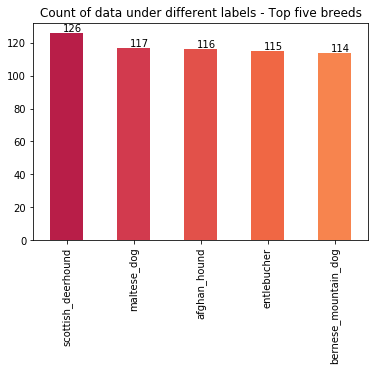

In [0]:
plt.subplots(figsize=(6,4)) 

ax = labels_df['breed'].value_counts().nlargest(5).plot.bar(color=sns.color_palette('Spectral',20))
ax.set_title('Count of data under different labels - Top five breeds')

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+.2,p.get_height()+1))


### Get one-hot encodings of labels

**I will do the encoding in the next step for ease of reading the data from train data and mapping it to the labels**

In [0]:
labels_df['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

**Setting image size as 128 x 128:**

In [0]:
img_rows = 128
img_cols = 128

**Loading train images:**

In [0]:
x_train = []
y_train = []

In [0]:
for img_id, breed in tqdm(labels_df.values):
  train_img = cv2.imread('/content/drive/My Drive/CNN/dog_breed/train/{}.jpg'.format(img_id), 1)
  train_img_resize = cv2.resize(train_img, (img_rows, img_cols)) 
  x_train.append(train_img_resize)
  y_train.append(breed)

100%|██████████| 10222/10222 [1:05:41<00:00,  1.97it/s]


**Saving the data in pickle file for future use:**

In [0]:
pickle_out = open("/content/drive/My Drive/CNN/dog_breed/x_train.pickle", "wb")
pickle.dump(x_train, pickle_out)
pickle_out.close()

In [0]:
pickle_out = open("/content/drive/My Drive/CNN/dog_breed/y_train.pickle", "wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

**Retrieve data from pickle file:**

In [0]:
pickle_in = open("/content/drive/My Drive/CNN/dog_breed/x_train.pickle", "rb")
x_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/CNN/dog_breed/y_train.pickle", "rb")
y_train = pickle.load(pickle_in)

**Let's view a sample image:**

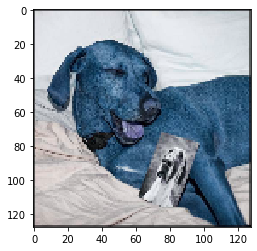

In [0]:
plt.imshow(x_train[100])

**Let's view the breed of the above image:**

In [0]:
y_train[100]

'rhodesian_ridgeback'

**Total data in y_train:**

In [0]:
len(y_train)

10222

**Let's view the count of unique breeds in the data:**

In [0]:
len(np.unique(y_train))

120

**Label encoding the data before applying one-hot encoding:**

In [0]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [0]:
len(np.unique(y_train))

120

**Let's check if data has been label encoded correctly:**

In [0]:
np.unique(y_train)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

In [0]:
y_train

array([19, 37, 85, ...,  3, 75, 28])

**Data before One-hot encoding:**

In [0]:
y_train[100]

90

**Encoding:**

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

**Data after One-hot encoding:**

In [0]:
y_train[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

**Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model:**

In [0]:
# Convert to array:
x_train = np.array(x_train)

In [0]:
# View shape of data:
x_train.shape

(10222, 128, 128, 3)

In [0]:
# View shape of labels:
y_train.shape

(10222, 120)

**Normalize the data:**

In [0]:
x_train = x_train.astype('float32')

In [0]:
x_train/=255

### **Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step**

In [0]:
x_t_train, x_val, y_t_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

### **Loading the test data**
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
ss_df = pd.read_csv('/content/drive/My Drive/CNN/dog_breed/sample_submission.csv')

In [0]:
ss_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [0]:
ss_df.shape

(10357, 121)

In [0]:
test_img = ss_df['id']

**Run the below code to load the test image files in x_test_feature**

In [0]:
x_test_feature = []

In [0]:
i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
    img = cv2.imread('/content/drive/My Drive/CNN/dog_breed/test/{}.jpg'.format(f), 1)
    img_resize = cv2.resize(img, (img_rows, img_cols)) 
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [1:05:07<00:00,  2.86it/s]


**Normalize the test data and convert it into 4 dimensions**

**Storing data in pickle file for future use:**

In [0]:
# pickle_out = open("/content/drive/My Drive/CNN/dog_breed/x_test_feature.pickle", "wb")
# pickle.dump(x_test_feature, pickle_out)
# pickle_out.close()

**Retrieve data from pickle file:**

In [0]:
pickle_in = open("/content/drive/My Drive/CNN/dog_breed/x_test_feature.pickle", "rb")
x_test_feature = pickle.load(pickle_in)

**Normalize data and verify the shape of data:**

In [0]:
x_test_feature = np.array(x_test_feature)

In [0]:
x_test_feature.shape

(10357, 128, 128, 3)

In [0]:
x_test_feature = x_test_feature.astype('float32')

In [0]:
x_test_feature/= 255

In [0]:
x_test_feature.shape

(10357, 128, 128, 3)

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
input_shape = (128, 128, 3)

In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), input_shape=input_shape, activation='relu', name='Conv_layer1'))
model.add(tf.keras.layers.MaxPool2D())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv_layer2'))
model.add(tf.keras.layers.MaxPool2D())
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu', name='Dense_layer'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name='Output'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Use batch_size = 128 and epochs = 10 and execute the model

In [0]:
model.fit(x_t_train, y_t_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)

Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 6s 718us/sample - loss: 4.8252 - accuracy: 0.0295 - val_loss: 4.7672 - val_accuracy: 0.0171
Epoch 2/10
8177/8177 [==============================] - 3s 377us/sample - loss: 3.6940 - accuracy: 0.1781 - val_loss: 5.0495 - val_accuracy: 0.0127
Epoch 3/10
8177/8177 [==============================] - 3s 375us/sample - loss: 1.8913 - accuracy: 0.6384 - val_loss: 5.5531 - val_accuracy: 0.0108
Epoch 4/10
8177/8177 [==============================] - 3s 372us/sample - loss: 0.2747 - accuracy: 0.9821 - val_loss: 6.6842 - val_accuracy: 0.0108
Epoch 5/10
8177/8177 [==============================] - 3s 374us/sample - loss: 0.0369 - accuracy: 0.9993 - val_loss: 6.9301 - val_accuracy: 0.0088
Epoch 6/10
8177/8177 [==============================] - 3s 374us/sample - loss: 0.0183 - accuracy: 0.9991 - val_loss: 7.2422 - val_accuracy: 0.0117
Epoch 7/10
8177/8177 [==============================] - 3s 376us

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_layer1 (Conv2D)         (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
Conv_layer2 (Conv2D)         (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

**Accuracy:**

In [0]:
loss, acc = model.evaluate(x_val, y_val)
print('Loss: {}, Accuracy: {}'.format(loss, acc))

2045/2045 [==============================] - 0s 230us/sample - loss: 5.0696 - accuracy: 0.0479
Loss: 5.069601439030654, Accuracy: 0.047921761870384216


#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
# On train set:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range = 50,
      zoom_range = 0.2,
      shear_range = 0.2,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

# On Validation set:
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range = 50,
      zoom_range = 0.2,
      shear_range = 0.2,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      horizontal_flip = True,
      fill_mode = 'nearest')

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
x_t_train.shape

(8177, 128, 128, 3)

In [0]:
train_gen_data = train_generator.flow(x_t_train, y_t_train, batch_size=32)

In [0]:
x_val.shape

(2045, 128, 128, 3)

In [0]:
val_gen_data = val_generator.flow(x_val, y_val, batch_size=32)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [0]:
type(train_gen_data)

keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator

In [0]:
model.fit_generator(train_gen_data, steps_per_epoch=50, validation_data=val_gen_data, validation_steps=50, epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 50 steps
Epoch 1/10
50/50 [==============================] - 13s 251ms/step - loss: 5.3348 - accuracy: 0.0144 - val_loss: 18.6580 - val_accuracy: 0.0113
Epoch 2/10
50/50 [==============================] - 12s 241ms/step - loss: 4.9926 - accuracy: 0.0259 - val_loss: 6.5548 - val_accuracy: 0.0213
Epoch 3/10
50/50 [==============================] - 12s 243ms/step - loss: 4.7833 - accuracy: 0.0347 - val_loss: 5.2847 - val_accuracy: 0.0256
Epoch 4/10
50/50 [==============================] - 12s 239ms/step - loss: 4.6846 - accuracy: 0.0456 - val_loss: 7.9914 - val_accuracy: 0.0175
Epoch 5/10
50/50 [==============================] - 12s 240ms/step - loss: 4.5890 - accuracy: 0.0388 - val_loss: 5.6165 - val_accuracy: 0.0181
Epoch 6/10
50/50 [==============================] - 12s 237ms/step - loss: 4.5635 - accuracy: 0.0413 - val_loss: 4.8

**Accuracy:**

In [0]:
loss, acc = model.evaluate(x_val, y_val)
print('Loss: {}, Accuracy: {}'.format(loss, acc))

2045/2045 [==============================] - 0s 216us/sample - loss: 5.6120 - accuracy: 0.0298
Loss: 5.611950367179069, Accuracy: 0.02982885017991066


# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
# from keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= tf.keras.applications.vgg16.VGG16(weights=(project_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False, pooling='avg')

Print the summary of the base_model

In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
flatten_layer = tf.keras.layers.Flatten()
dense_layer1  = tf.keras.layers.Dense(1024, activation='relu', name='dense_layer1')
dense_layer2  = tf.keras.layers.Dense(256, activation='relu', name='dense_layer2')
output_layer  = tf.keras.layers.Dense(120, activation='softmax', name='output')

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
base_model.trainable = False

print(base_model.trainable_weights)

[]


In [0]:
model_vgg_mod = tf.keras.models.Sequential([base_model, flatten_layer, dense_layer1, dense_layer2, output_layer])

In [0]:
model_vgg_mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 1024)              525312    
_________________________________________________________________
dense_layer2 (Dense)         (None, 256)               262400    
_________________________________________________________________
output (Dense)               (None, 120)               30840     
Total params: 15,533,240
Trainable params: 818,552
Non-trainable params: 14,714,688
_________________________________________________________________


### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
x_t_train.shape

(8177, 128, 128, 3)

In [0]:
y_t_train.shape

(8177, 120)

In [0]:
x_val.shape

(2045, 128, 128, 3)

In [0]:
y_val.shape

(2045, 120)

In [0]:
model_vgg_mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model_vgg_mod.fit(x_t_train, y_t_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)

Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 11s 1ms/sample - loss: 4.7222 - accuracy: 0.0265 - val_loss: 4.5408 - val_accuracy: 0.0509
Epoch 2/10
8177/8177 [==============================] - 8s 943us/sample - loss: 4.2813 - accuracy: 0.0766 - val_loss: 4.0401 - val_accuracy: 0.0944
Epoch 3/10
8177/8177 [==============================] - 8s 946us/sample - loss: 3.7520 - accuracy: 0.1355 - val_loss: 3.6732 - val_accuracy: 0.1438
Epoch 4/10
8177/8177 [==============================] - 8s 957us/sample - loss: 3.3945 - accuracy: 0.1908 - val_loss: 3.5157 - val_accuracy: 0.1545
Epoch 5/10
8177/8177 [==============================] - 8s 959us/sample - loss: 3.1675 - accuracy: 0.2320 - val_loss: 3.3313 - val_accuracy: 0.1844
Epoch 6/10
8177/8177 [==============================] - 8s 954us/sample - loss: 3.0085 - accuracy: 0.2550 - val_loss: 3.2787 - val_accuracy: 0.2059
Epoch 7/10
8177/8177 [==============================] - 8s 955us/

In [0]:
loss, acc = model_vgg_mod.evaluate(x_val, y_val)
print('Loss: {}, Accuracy: {}'.format(loss, acc))

2045/2045 [==============================] - 2s 1ms/sample - loss: 3.1466 - accuracy: 0.2244
Loss: 3.1466466906018247, Accuracy: 0.22444987297058105


**Inference:**

Accuracy is still poor. Let's try VGG16 after resizing the images to size 224x224

### **Resize images into size 224x224:**

In [0]:
img_rows_vgg = 224
img_cols_vgg = 224

In [0]:
x_train_vgg = []
y_train_vgg = []

In [0]:
for img_id, breed in tqdm(labels_df.values):
  train_img = cv2.imread('/content/drive/My Drive/CNN/dog_breed/train/{}.jpg'.format(img_id), 1)
  train_img_resize = cv2.resize(train_img, (img_rows_vgg, img_cols_vgg)) 
  # train_img_arr = image.img_to_array(train_img_resize) 
  # train_img_arr_1 = np.expand_dims(train_img_arr, axis=0)
  x_train_vgg.append(train_img_resize)
  y_train_vgg.append(breed)

**Store the data in pickle file:**

In [0]:
pickle_out = open("/content/drive/My Drive/CNN/dog_breed/x_train_vgg.pickle", "wb")
pickle.dump(x_train_vgg, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/CNN/dog_breed/y_train_vgg.pickle", "wb")
pickle.dump(y_train_vgg, pickle_out)
pickle_out.close()

**Retrieve the data from pickle file:**

In [0]:
pickle_in = open("/content/drive/My Drive/CNN/dog_breed/x_train_vgg.pickle", "rb")
x_train_vgg = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/CNN/dog_breed/y_train_vgg.pickle", "rb")
y_train_vgg = pickle.load(pickle_in)

**View the shape of resized data:**

In [0]:
x_train_vgg[0].shape

(224, 224, 3)

**View one of the images after resizing:**

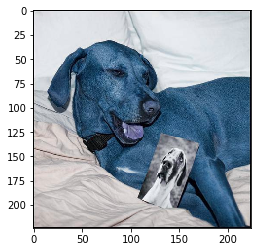

In [0]:
plt.imshow(x_train_vgg[100])

**Normalize the data:**

In [0]:
x_train_vgg = np.array(x_train_vgg)

In [0]:
x_train_vgg.shape

(10222, 224, 224, 3)

In [0]:
x_train_vgg = x_train_vgg.astype('float32')

In [0]:
x_train_vgg/= 255

**One-hot encoding of labels:**

In [0]:
le = LabelEncoder()
y_train_vgg = le.fit_transform(y_train_vgg)
y_train_vgg = tf.keras.utils.to_categorical(y_train_vgg, num_classes=num_classes)

In [0]:
y_train_vgg[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

**Split the data into train and test:**

In [0]:
x_t_train1, x_val1, y_t_train1, y_val1 = train_test_split(x_train_vgg, y_train_vgg, test_size=0.2, random_state=0, stratify=y_train_vgg)

**Build a sequential model:**

In [0]:
input_shape_new = (224, 224, 3)

In [0]:
model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), input_shape=input_shape_new, activation='relu', name='Conv_layer1'))
model1.add(tf.keras.layers.MaxPool2D())
# model1.add(tf.keras.layers.Dropout(0.1))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv_layer2'))
model1.add(tf.keras.layers.MaxPool2D())
# model1.add(tf.keras.layers.Dropout(0.1))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(256, activation='relu', name='Dense_layer'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dropout(0.1))

model1.add(tf.keras.layers.Dense(num_classes, activation='softmax', name='Output'))

**Compile:**

In [0]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Fit the model in train data and validate against validation data:**

In [0]:
model1.fit(x_t_train1, y_t_train1, validation_data=(x_val1, y_val1), epochs=10, batch_size=128)

Train on 8177 samples, validate on 2045 samples
Epoch 1/10
8177/8177 [==============================] - 10s 1ms/sample - loss: 4.8672 - accuracy: 0.0300 - val_loss: 4.8004 - val_accuracy: 0.0127
Epoch 2/10
8177/8177 [==============================] - 8s 1ms/sample - loss: 3.8892 - accuracy: 0.1379 - val_loss: 5.0425 - val_accuracy: 0.0103
Epoch 3/10
8177/8177 [==============================] - 8s 1ms/sample - loss: 2.0634 - accuracy: 0.5941 - val_loss: 5.3137 - val_accuracy: 0.0098
Epoch 4/10
8177/8177 [==============================] - 8s 1ms/sample - loss: 0.2664 - accuracy: 0.9828 - val_loss: 5.8752 - val_accuracy: 0.0078
Epoch 5/10
8177/8177 [==============================] - 8s 1ms/sample - loss: 0.0364 - accuracy: 0.9988 - val_loss: 6.4824 - val_accuracy: 0.0108
Epoch 6/10
8177/8177 [==============================] - 8s 1ms/sample - loss: 0.0160 - accuracy: 0.9990 - val_loss: 6.7159 - val_accuracy: 0.0112
Epoch 7/10
8177/8177 [==============================] - 8s 999us/sample - l

**View Summary of model:**

In [0]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_layer1 (Conv2D)         (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 110, 110, 32)      128       
_________________________________________________________________
Conv_layer2 (Conv2D)         (None, 108, 108, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 54, 54, 64)        256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 186624)           

**Accuracy:**

In [0]:
loss, acc = model1.evaluate(x_val1, y_val1)
print('Loss: {}, Accuracy: {}'.format(loss, acc))

2045/2045 [==============================] - 1s 530us/sample - loss: 5.1190 - accuracy: 0.0386
Loss: 5.119012973244441, Accuracy: 0.038630805909633636


### As seen earlier, accuracy is poor even after image resizing

**Let's try image augmentation:**

In [0]:
train_gen_data1 = train_generator.flow(x_t_train1, y_t_train1, batch_size=32)
val_gen_data1 = val_generator.flow(x_val1, y_val1, batch_size=32)

In [0]:
model1.fit_generator(train_gen_data1, steps_per_epoch=50, validation_data=val_gen_data1, validation_steps=50, epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 50 steps
Epoch 1/10
50/50 [==============================] - 34s 677ms/step - loss: 5.1728 - accuracy: 0.0233 - val_loss: 24.0690 - val_accuracy: 0.0094
Epoch 2/10
50/50 [==============================] - 34s 675ms/step - loss: 4.8972 - accuracy: 0.0250 - val_loss: 7.5402 - val_accuracy: 0.0206
Epoch 3/10
50/50 [==============================] - 34s 682ms/step - loss: 4.6996 - accuracy: 0.0366 - val_loss: 7.3652 - val_accuracy: 0.0194
Epoch 4/10
50/50 [==============================] - 34s 681ms/step - loss: 4.7209 - accuracy: 0.0406 - val_loss: 5.7744 - val_accuracy: 0.0237
Epoch 5/10
50/50 [==============================] - 34s 676ms/step - loss: 4.6050 - accuracy: 0.0435 - val_loss: 5.1601 - val_accuracy: 0.0344
Epoch 6/10
50/50 [==============================] - 34s 680ms/step - loss: 4.5520 - accuracy: 0.0475 - val_loss: 4.9515 - val_accuracy: 0.0306
Epoch 7/10
50/50 [==============================]

In [0]:
# Accuracy:
loss, acc = model1.evaluate(x_val1, y_val1)
print('Loss: {}, Accuracy: {}'.format(loss, acc))

2045/2045 [==============================] - 1s 494us/sample - loss: 4.5386 - accuracy: 0.0572
Loss: 4.538603742781362, Accuracy: 0.0572127141058445


### Accuracy is poor once again! Let's follow the earlier step of using transfer learning

**VGG16 Transfer Learning:**

In [0]:
base_model.trainable = False
print(base_model.trainable_weights)

[]


In [0]:
model_vgg_mod_updt = tf.keras.models.Sequential([base_model, flatten_layer, dense_layer1, dense_layer2, output_layer])

**Model Summary:**

In [0]:
model_vgg_mod_updt.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 1024)              525312    
_________________________________________________________________
dense_layer2 (Dense)         (None, 256)               262400    
_________________________________________________________________
output (Dense)               (None, 120)               30840     
Total params: 15,533,240
Trainable params: 818,552
Non-trainable params: 14,714,688
_________________________________________________________________


**Compile the model:**

In [0]:
model_vgg_mod_updt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Fit the model:**

### Im trying with 100 epochs this time so that the model will have some learning space

In [0]:
model_vgg_mod_updt.fit(x_t_train1, y_t_train1, validation_data=(x_val1, y_val1), epochs=100, batch_size=128)

Train on 8177 samples, validate on 2045 samples
Epoch 1/100
8177/8177 [==============================] - 30s 4ms/sample - loss: 2.5685 - accuracy: 0.3447 - val_loss: 2.7439 - val_accuracy: 0.2866
Epoch 2/100
8177/8177 [==============================] - 23s 3ms/sample - loss: 2.3542 - accuracy: 0.3844 - val_loss: 2.7076 - val_accuracy: 0.3007
Epoch 3/100
8177/8177 [==============================] - 23s 3ms/sample - loss: 2.2322 - accuracy: 0.4096 - val_loss: 2.6027 - val_accuracy: 0.3169
Epoch 4/100
8177/8177 [==============================] - 23s 3ms/sample - loss: 2.1468 - accuracy: 0.4282 - val_loss: 2.5953 - val_accuracy: 0.3198
Epoch 5/100
8177/8177 [==============================] - 23s 3ms/sample - loss: 2.0865 - accuracy: 0.4383 - val_loss: 2.5451 - val_accuracy: 0.3335
Epoch 6/100
8177/8177 [==============================] - 23s 3ms/sample - loss: 2.0120 - accuracy: 0.4563 - val_loss: 2.5927 - val_accuracy: 0.3198
Epoch 7/100
8177/8177 [==============================] - 23s 3ms

**Accuracy:**

In [0]:
loss, acc = model_vgg_mod_updt.evaluate(x_val1, y_val1)
print('Loss: {}, Accuracy: {}'.format(loss, acc))

2045/2045 [==============================] - 6s 3ms/sample - loss: 5.0573 - accuracy: 0.3550
Loss: 5.057316117065168, Accuracy: 0.3550122380256653


### **Inference:**

### We can see that train accuracy is almost 100, whereas the validation accuracy is still poor. However it is better compared to the earlier tries.

**Predict on validation data:**

In [0]:
y_pred = model_vgg_mod_updt.predict_classes(x_val1)

**Classification report:**

In [0]:
print(classification_report(y_val1.argmax(axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.60      0.38      0.46        16
           1       0.74      0.61      0.67        23
           2       0.67      0.71      0.69        17
           3       0.30      0.27      0.29        22
           4       0.30      0.20      0.24        15
           5       0.35      0.38      0.36        16
           6       0.40      0.48      0.43        21
           7       0.55      0.55      0.55        22
           8       0.29      0.25      0.27        16
           9       0.21      0.33      0.25        21
          10       0.50      0.50      0.50        18
          11       0.65      0.57      0.60        23
          12       0.29      0.33      0.31        15
          13       0.59      0.62      0.60        21
          14       0.21      0.18      0.19        17
          15       0.32      0.35      0.33        17
          16       0.44      0.50      0.47        14
          17       0.24    

### *   We can see that the model has not performed very well in classifying the breed of dogs. The classification report also shows the same
### *   Some images had humans in the background which might have created additional unwanted edges and the accuracy would have dropped in such scenarios




## **Overall Summary:**

- Imported the necessary libraries
- Unzipped the data and placed the files in drive
- Read the labels.csv file and performed the necessary analysis.
- Mapped the training images with the labels from the labels.csv file and normalized the training data
- Similarly test images were mapped with their corresponding labels from sample_submission.csv file. Normalized test data.
- Stored the data in pickle files for future use
- Images were resized to 128x128
- Built a basic convolutional neural network model with 2 conv layers. Accuracy was poor.
- Tried image augmentation and then tried training the same model. This also didn't help much in improving the accuracy
- Made use of transfer learning using VGG16 with all its layers as non-trainable. This time accuracy slightly increased to 22.44%
- Now, resized the images to 224x224 to check if this impacts the accuracy
- This time transfer learning using VGG16 gave a validation accuracy of35.5%, where as the train accuracy was almost 99.9%
- The model has not performed well in classifying the breed of dogs. The data had human beings as well in the background in some images which would have created unwanted edges and that might have resulted in a poor accuracy

### <center> **End of CV_Project2_Dog_Breed_Classification Project**</center>